In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

font = {'family':'SimHei','weight':'bold', 'size':16}
matplotlib.rc('font', **font)

In [2]:
df_goods = pd.read_csv(r'小组项目数据_合并了四月流失.csv')
df_goods.head(5)

,member_id,transaction_id,date,time,class_id,class,subclass_id,subclass,quantity,amount,cost,price,Attrition (Y)
0,1449,381510,20130331,1931,57,罐头食品,39,PICKLED VEGETABLE,1.00,7.90,5.84,7.90,0
1,6183,381519,20130331,1954,151,厨房用品,69,CON.KITCHENWARE,1.00,10.00,6.97,10.00,1
2,6183,381519,20130331,1954,200,家用一次性用品,346,DISP.PLASTIC CUPS,4.00,43.60,6.77,10.90,1
3,6183,381519,20130331,1954,165,笔记本/纸,857,COPY PAPER,1.00,32.80,26.31,32.80,1
4,6780,639377,20130331,851,47,蛋品,561,SCOOP EGG,1.96,15.32,8.50,7.82,0


In [3]:
# External File which has pre-defined metadata of raw_data
raw_data = pd.read_csv(r"raw_model.csv")
print(len(df_goods['class'].unique()))

classes = df_goods.apply(lambda row: str(row['class_id']).zfill(3)+'_'+row['class'], axis = 1).unique()
pd.Series(classes).to_csv('class_group.csv')

## offline produced into different parent classes
df_categrozied = pd.read_csv(r"class_group_categorized.csv").sort_values(by='parent_class',ascending=True)
df_categrozied

190


,Unnamed: 0,class_full,parent_class
0,20,001_绿叶蔬菜,00_蔬菜水果
7,72,008_豆制品,00_蔬菜水果
6,24,007_新鲜水果,00_蔬菜水果
5,167,006_无毒蔬菜,00_蔬菜水果
58,37,061_dried 蔬果,00_蔬菜水果
...,...,...,...
181,158,191_学习机/电子词典,19_数码产品
182,91,192_寄售vcd,19_数码产品
177,13,187_手机,19_数码产品
176,147,186_数码信息,19_数码产品


In [4]:
# Get the number of transactions
print(len(df_goods['transaction_id'].unique()))
# Get the number of total customers
print(len(df_goods['member_id'].unique()))

27448
10000


In [5]:
#get boolean for transaction time flag
# option : 0 weekMorning
# option : 1 weekEnening
# option : 2 weekNorm
# option : 3 weekend
def get_transaction_time_flag(value, date,time,option):
    dateObj = datetime.strptime(str(date),'%Y%m%d')
    if option == 0:
        if dateObj.weekday() < 5 and int(time) < 900:
            return value
    elif option ==  1:
        if dateObj.weekday() < 5 and int(time) >= 1800:
            return value
    elif option == 2:
        if dateObj.weekday() < 5 and int(time) >= 900 and int(time) < 1800:
            return value
    elif option == 3:
        if dateObj.weekday() >= 5:
            return value
    else:
        return 0
    return 0

# unit test for function
# print(get_transaction_time_flag('123456','20130322','1426',0))
# print(get_transaction_time_flag('123456','20130322','1426',1))
# print(get_transaction_time_flag('123456','20130322','1426',2))

#get statitiscs data based on customer for filling raw_model
def get_Statistics(df):
    #Make copy to avoid link set warning
    df_tmp = df.copy()
    #Calculate to get value for each customer in multi dimension
    member_id = df_tmp['member_id'].min()
    transaction_count = len(df_tmp['transaction_id'].unique())
    interval_avg =  (20130331 - df_tmp['date'].min() + 1) / transaction_count
    elapsed_days = 20130331 - df_tmp['date'].max() + 1
    amount_total = df_tmp['amount'].sum()
    amount_transaction_avg = amount_total / transaction_count
    class_total = len(df_tmp['class'].unique())
    week_count = len((df_tmp['date'] / 7).astype(int).unique())
    
    df_tmp['timeflag_0'] = df_tmp.apply(lambda row:get_transaction_time_flag(row['transaction_id'],
                                                                     row['date'],row['time'],0),axis=1)
    df_tmp['timeflag_1'] = df_tmp.apply(lambda row:get_transaction_time_flag(row['transaction_id'],
                                                                     row['date'],row['time'],1),axis=1)
    df_tmp['timeflag_2'] = df_tmp.apply(lambda row:get_transaction_time_flag(row['transaction_id'],
                                                                     row['date'],row['time'],2),axis=1)
    df_tmp['timeflag_3'] = df_tmp.apply(lambda row:get_transaction_time_flag(row['transaction_id'],
                                                                     row['date'],row['time'],3),axis=1)
    df_tmp['amount_0'] = df_tmp.apply(lambda row:get_transaction_time_flag(row['amount'],
                                                                     row['date'],row['time'],0),axis=1)
    df_tmp['amount_1'] = df_tmp.apply(lambda row:get_transaction_time_flag(row['amount'],
                                                                     row['date'],row['time'],1),axis=1)
    df_tmp['amount_2'] = df_tmp.apply(lambda row:get_transaction_time_flag(row['amount'],
                                                                     row['date'],row['time'],2),axis=1)
    df_tmp['amount_3'] = df_tmp.apply(lambda row:get_transaction_time_flag(row['amount'],
                                                                     row['date'],row['time'],3),axis=1)
    #print(df_tmp)
    # nonzero ditinct count
    s_zero = pd.Series([0]) 
    weekMoning_count = len(df_tmp['timeflag_0'].append(s_zero).unique()) - 1
    weekEvening_count = len(df_tmp['timeflag_1'].append(s_zero).unique()) - 1
    weekNorm_count = len(df_tmp['timeflag_2'].append(s_zero).unique()) - 1
    weekend_count = len(df_tmp['timeflag_3'].append(s_zero).unique()) - 1
    
    # get amount for different timewindows
    weekMoning_amount = df_tmp['amount_0'].sum()
    weekEvening_amount = df_tmp['amount_1'].sum()
    weekNorm_amount = df_tmp['amount_2'].sum()
    weekend_amount = df_tmp['amount_3'].sum()
    
    attrition = df_tmp['Attrition (Y)'].max()
    
    row = pd.Series([member_id,transaction_count,interval_avg,elapsed_days,amount_total,
                     amount_transaction_avg,class_total,week_count,weekMoning_count,
                     weekEvening_count,weekNorm_count,weekend_count,weekMoning_amount,
                     weekEvening_amount,weekNorm_amount,weekend_amount,attrition],
                    index=raw_data.columns)
    return row

In [6]:
# unit test for funtion get_Statistics
df_1 = df_goods[df_goods['member_id'] == 2728]
get_Statistics(df_1)

member_id                 2728.00
transaction_count            1.00
interval_avg                10.00
elapsed_days                10.00
amount_total                62.13
amount_transaction_avg      62.13
class_total                  3.00
week_count                   1.00
weekMorning_count            0.00
weekEvening_count            0.00
weekNorm_count               1.00
weekend_count                0.00
weekMorning_amount           0.00
weekEvening_amount           0.00
weekNorm_amount             62.13
weekend_amunt                0.00
attrition                    1.00
dtype: float64

In [7]:
# Creating raw_data for analysis
count = 0
total = len(df_goods['member_id'].unique())
raw_data = raw_data.drop(index = raw_data.index)

print(str(datetime.now()) + ' : ' + 'processing started')

for member_id in df_goods['member_id'].unique():
    row = get_Statistics(df_goods[df_goods['member_id'] == member_id])
    raw_data = raw_data.append(row, ignore_index=True)
    count += 1
    if count%500 == 0:
        print(str(datetime.now()) + ' : ' + str(count) + ' of ' + str(total) + ' completed')

raw_data = raw_data.infer_objects()
raw_data.to_csv(r'raw_data.csv')

raw_data.head(5)

2021-04-19 23:22:13.036401 : processing started
2021-04-19 23:22:20.718052 : 500 of 10000 completed
2021-04-19 23:22:27.989465 : 1000 of 10000 completed
2021-04-19 23:22:35.278016 : 1500 of 10000 completed
2021-04-19 23:22:42.358803 : 2000 of 10000 completed
2021-04-19 23:22:49.460469 : 2500 of 10000 completed
2021-04-19 23:22:56.364357 : 3000 of 10000 completed
2021-04-19 23:23:03.196476 : 3500 of 10000 completed
2021-04-19 23:23:09.975297 : 4000 of 10000 completed
2021-04-19 23:23:16.792659 : 4500 of 10000 completed
2021-04-19 23:23:23.342058 : 5000 of 10000 completed
2021-04-19 23:23:29.743821 : 5500 of 10000 completed
2021-04-19 23:23:36.369483 : 6000 of 10000 completed
2021-04-19 23:23:43.850775 : 6500 of 10000 completed
2021-04-19 23:23:50.072077 : 7000 of 10000 completed
2021-04-19 23:23:56.256856 : 7500 of 10000 completed
2021-04-19 23:24:02.380881 : 8000 of 10000 completed
2021-04-19 23:24:08.574835 : 8500 of 10000 completed
2021-04-19 23:24:14.516004 : 9000 of 10000 completed

,member_id,transaction_count,interval_avg,elapsed_days,amount_total,amount_transaction_avg,class_total,week_count,weekMorning_count,weekEvening_count,weekNorm_count,weekend_count,weekMorning_amount,weekEvening_amount,weekNorm_amount,weekend_amunt,attrition
0,1449.0,3.0,5.666667,1.0,385.51,128.503333,20.0,3.0,0.0,1.0,0.0,2.0,0.0,100.61,0.00,284.90,0.0
1,6183.0,2.0,0.500000,1.0,243.80,121.900000,7.0,1.0,0.0,0.0,0.0,2.0,0.0,0.00,0.00,243.80,1.0
2,6780.0,5.0,4.000000,1.0,400.74,80.148000,22.0,3.0,0.0,1.0,0.0,4.0,0.0,95.99,0.00,304.75,0.0
3,112.0,4.0,4.500000,1.0,270.53,67.632500,12.0,3.0,0.0,1.0,1.0,2.0,0.0,45.03,164.26,61.24,0.0
4,5058.0,3.0,0.333333,1.0,405.20,135.066667,5.0,1.0,0.0,0.0,0.0,3.0,0.0,0.00,0.00,405.20,0.0


/Users/i064388/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/i064388/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


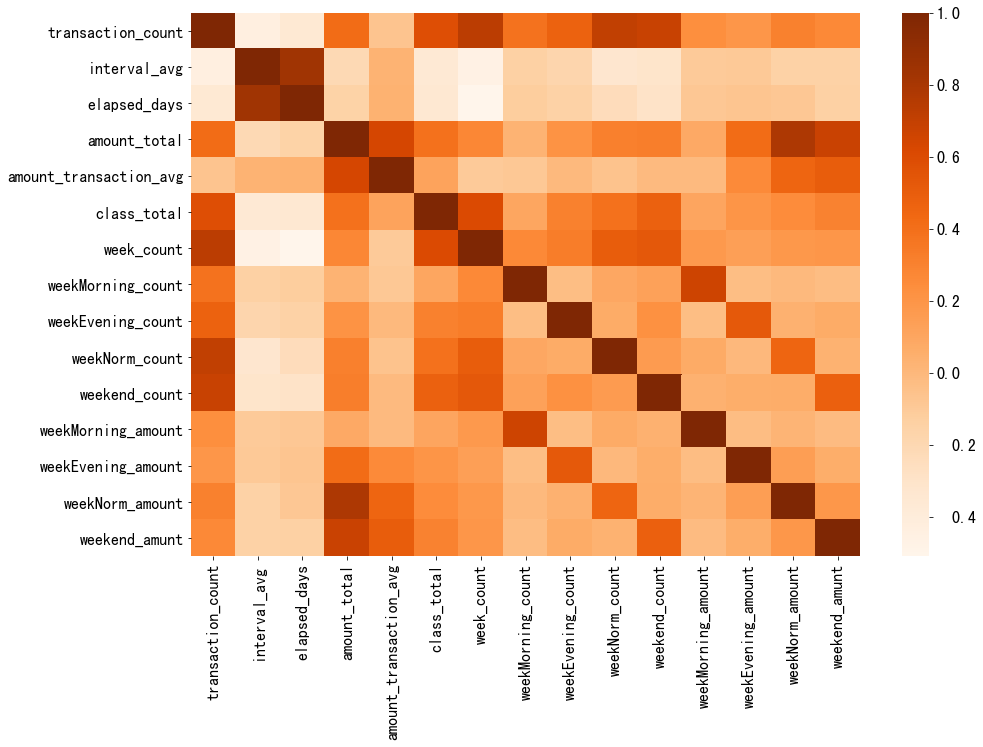

In [8]:
x_data = raw_data.drop(['member_id','attrition'],axis=1) 
y_data = raw_data['attrition']

#create a heatmap for the raw_data
corr = x_data.corr()
plt.subplots(figsize=(15, 10))
sns.heatmap(corr, annot=False, vmax=1, square=False, cmap="Oranges")
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# split train and test data
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.25, random_state=42)


# basic function to plot AUC chart
def plot_auc(y, prediction,y_train, y_prediction_train):
    fpr, tpr, threshold = metrics.roc_curve(y, prediction)
    _fpr, _tpr, _threshold = metrics.roc_curve(y_train, y_prediction_train)
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc2 = metrics.auc(_fpr, _tpr)
    plt.title('Validation ROC')
    plt.plot(fpr, tpr, 'b', label = 'x_test AUC = %0.3f' % roc_auc)
    plt.plot(_fpr, _tpr, 'r', label = 'x_train AUC = %0.3f' % roc_auc2)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate') 

# basic function to plot Confusion Matrix
def plot_confusion_matrix(y_test,result):
    plt.figure()
    plt.figure(figsize=(6,6))
    cm = confusion_matrix(y_test, result)
    labels = ['Positive','Negative']
    sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d',cmap='Oranges',vmin=0.2)
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    print('confusion matrix')
    plt.show()

Precision Score is  0.5517241379310345
Recall Score is  0.024279210925644917
[[1828   13]
 [ 643   16]]


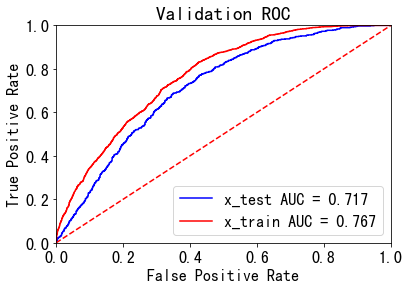

In [10]:
# Random Forrest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=14, max_depth=6, max_features='auto', 
                           criterion='entropy',n_estimators=200)
model_rf = rf.fit(train_x, train_y)

prediction = model_rf.predict_proba(test_x)[:,1]
result = model_rf.predict(test_x)
print('Precision Score is ',precision_score(test_y, result))
print('Recall Score is ',recall_score(test_y, result))
print(confusion_matrix(test_y, result))
plot_auc(test_y,prediction, train_y, model_rf.predict_proba(train_x)[:,1])
plt.show()

[23:24:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { colsample_btree, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Precision Score is  0.4019180470793374
Recall Score is  0.6995447647951442
[[1155  686]
 [ 198  461]]


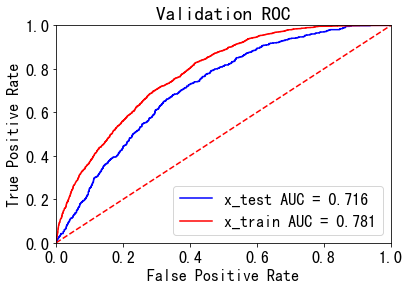

In [11]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(learning_rate=0.07, 
                          n_estimators=1000,         
                          max_depth=5,               
                          min_child_weight = 1,      
                          gamma=0.,                  
                          subsample=0.5,             
                          colsample_btree=0.5,       
                          objective='rank:pairwise',
                          #num_class = 2,
                          booster = 'gbtree',
                          scale_pos_weight=1,        
                          random_state=27)

model_xgb.fit(train_x,train_y,
              eval_set = [(test_x,test_y)],
              eval_metric = "auc",
              early_stopping_rounds = 30,
              verbose = False)

prediction = model_xgb.predict_proba(test_x)[:,1]
result = model_xgb.predict(test_x)
print('Precision Score is ',precision_score(test_y, result))
print('Recall Score is ',recall_score(test_y, result))
print(confusion_matrix(test_y, result))
plot_auc(test_y,prediction,train_y,model_xgb.predict_proba(train_x)[:,1])
plt.show()

In [12]:
# define a function to combine all transactions of a specidic customer into a weekly basket
# using member_id + weeknumber to make a virtual basket index
# 20130304 was a monday, so all the date would be transit through 
# (date - 20130298) for calculating number of weeks elapsed since then
def getBasketNumber(member_id,date):
    return str(member_id) + '_' + str(int((int(date) - 20130298)/7))

# unit test
#print(getBasketNumber('123','20130322'))
#print(getBasketNumber('123','20130323'))

#adding basket_no column into raw purchasing data
df_goods['basket_no'] = df_goods.apply(lambda row:getBasketNumber(row['member_id'],row['date']), axis = 1)
df_goods['class_full'] = df_goods.apply(lambda row:str(row['class_id']).zfill(3) + '_' + row['class'], axis = 1)
df_goods.head(5)

,member_id,transaction_id,date,time,class_id,class,subclass_id,subclass,quantity,amount,cost,price,Attrition (Y),basket_no,class_full
0,1449,381510,20130331,1931,57,罐头食品,39,PICKLED VEGETABLE,1.00,7.90,5.84,7.90,0,1449_4,057_罐头食品
1,6183,381519,20130331,1954,151,厨房用品,69,CON.KITCHENWARE,1.00,10.00,6.97,10.00,1,6183_4,151_厨房用品
2,6183,381519,20130331,1954,200,家用一次性用品,346,DISP.PLASTIC CUPS,4.00,43.60,6.77,10.90,1,6183_4,200_家用一次性用品
3,6183,381519,20130331,1954,165,笔记本/纸,857,COPY PAPER,1.00,32.80,26.31,32.80,1,6183_4,165_笔记本/纸
4,6780,639377,20130331,851,47,蛋品,561,SCOOP EGG,1.96,15.32,8.50,7.82,0,6780_4,047_蛋品


In [13]:
df_basket_raw = df_goods.pivot_table(columns = "class_full",
                                     index="basket_no",values="quantity",aggfunc=np.sum).fillna(0)
df_basket_raw.head(5)

class_full,001_绿叶蔬菜,002_根茎蔬菜,003_水果蔬菜,004_包装蔬菜,005_菇类蔬菜,006_无毒蔬菜,007_新鲜水果,008_豆制品,009_花卉园艺,010_茶叶,...,190_电脑及配件,191_学习机/电子词典,192_寄售vcd,193_男鞋,194_女鞋,195_童鞋,196_运动帆布鞋,197_电视,198_餐具,200_家用一次性用品
basket_no,,,,,,,,,,,,,,,,,,,,,
10000_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1000_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.45,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# define a function to encode buy/no buy into boolean
def encode_units(x):
    if x == 0:
        return False
    else:
        return True
    
df_basket = df_basket_raw.applymap(encode_units)
df_basket.head(5)
df_basket

class_full,001_绿叶蔬菜,002_根茎蔬菜,003_水果蔬菜,004_包装蔬菜,005_菇类蔬菜,006_无毒蔬菜,007_新鲜水果,008_豆制品,009_花卉园艺,010_茶叶,...,190_电脑及配件,191_学习机/电子词典,192_寄售vcd,193_男鞋,194_女鞋,195_童鞋,196_运动帆布鞋,197_电视,198_餐具,200_家用一次性用品
basket_no,,,,,,,,,,,,,,,,,,,,,
10000_0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1000_3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1001_1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1002_4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1003_2,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999_1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
999_3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
99_1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(df_basket, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

#print(frequent_itemsets)
df_support_100 = rules.sort_values(by = 'support' , ascending = False).head(100)
df_support_100.to_csv('support100.csv')
df_support_100

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(001_绿叶蔬菜),(007_新鲜水果),0.163755,0.304845,0.082086,0.501270,1.644343,0.032166,1.393850
5,(007_新鲜水果),(001_绿叶蔬菜),0.304845,0.163755,0.082086,0.269270,1.644343,0.032166,1.144396
52,(008_豆制品),(007_新鲜水果),0.178571,0.304845,0.071273,0.399127,1.309277,0.016836,1.156908
53,(007_新鲜水果),(008_豆制品),0.304845,0.178571,0.071273,0.233799,1.309277,0.016836,1.072080
61,(007_新鲜水果),(020_其他肉类),0.304845,0.176232,0.067322,0.220839,1.253115,0.013598,1.057250
...,...,...,...,...,...,...,...,...,...
439,(140_卫生巾/护垫),(137_纸巾),0.091443,0.146444,0.036858,0.403070,2.752380,0.023467,1.429909
323,(137_纸巾),(051_调味品),0.146444,0.194583,0.036858,0.251686,1.293464,0.008362,1.076309
322,(051_调味品),(137_纸巾),0.194583,0.146444,0.036858,0.189420,1.293464,0.008362,1.053019
300,(051_调味品),(058_面食),0.194583,0.124038,0.036182,0.185947,1.499111,0.012046,1.076050


In [16]:
df_confidence_10 = df_support_100.sort_values(by = 'confidence' , ascending = False).head(10)
df_confidence_10.to_csv('confidence10.csv')
df_confidence_10

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(001_绿叶蔬菜),(007_新鲜水果),0.163755,0.304845,0.082086,0.501270,1.644343,0.032166,1.393850
28,(002_根茎蔬菜),(007_新鲜水果),0.118112,0.304845,0.054897,0.464789,1.524672,0.018891,1.298842
42,(003_水果蔬菜),(007_新鲜水果),0.106571,0.304845,0.049335,0.462927,1.518564,0.016847,1.294339
1,(002_根茎蔬菜),(001_绿叶蔬菜),0.118112,0.163755,0.050166,0.424736,2.593721,0.030825,1.453671
297,(053_酱油/醋),(051_调味品),0.110626,0.194583,0.046371,0.419173,2.154211,0.024845,1.386673
439,(140_卫生巾/护垫),(137_纸巾),0.091443,0.146444,0.036858,0.403070,2.752380,0.023467,1.429909
52,(008_豆制品),(007_新鲜水果),0.178571,0.304845,0.071273,0.399127,1.309277,0.016836,1.156908
72,(043_低温酸奶),(007_新鲜水果),0.156997,0.304845,0.061291,0.390397,1.280642,0.013431,1.140341
68,(031_面包),(007_新鲜水果),0.152059,0.304845,0.058484,0.384615,1.261675,0.012130,1.129627
387,(080_糖果),(076_干脆小食),0.100177,0.157673,0.038418,0.383498,2.432232,0.022622,1.366300


In [17]:
# RFM Analysis
# Recency / Frequency / Monetary
raw_data.head(10)

,member_id,transaction_count,interval_avg,elapsed_days,amount_total,amount_transaction_avg,class_total,week_count,weekMorning_count,weekEvening_count,weekNorm_count,weekend_count,weekMorning_amount,weekEvening_amount,weekNorm_amount,weekend_amunt,attrition
0,1449.0,3.0,5.666667,1.0,385.51,128.503333,20.0,3.0,0.0,1.0,0.0,2.0,0.0,100.61,0.00,284.90,0.0
1,6183.0,2.0,0.500000,1.0,243.80,121.900000,7.0,1.0,0.0,0.0,0.0,2.0,0.0,0.00,0.00,243.80,1.0
2,6780.0,5.0,4.000000,1.0,400.74,80.148000,22.0,3.0,0.0,1.0,0.0,4.0,0.0,95.99,0.00,304.75,0.0
3,112.0,4.0,4.500000,1.0,270.53,67.632500,12.0,3.0,0.0,1.0,1.0,2.0,0.0,45.03,164.26,61.24,0.0
4,5058.0,3.0,0.333333,1.0,405.20,135.066667,5.0,1.0,0.0,0.0,0.0,3.0,0.0,0.00,0.00,405.20,0.0
5,4259.0,1.0,1.000000,1.0,756.00,756.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00,0.00,756.00,1.0
6,6197.0,5.0,3.000000,1.0,1076.30,215.260000,15.0,3.0,0.0,0.0,0.0,5.0,0.0,0.00,0.00,1076.30,1.0
7,7151.0,4.0,5.250000,1.0,2130.40,532.600000,4.0,3.0,0.0,0.0,2.0,2.0,0.0,0.00,472.50,1657.90,0.0
8,6455.0,4.0,2.750000,1.0,429.30,107.325000,25.0,2.0,0.0,0.0,2.0,2.0,0.0,0.00,271.43,157.87,0.0
9,3519.0,7.0,3.428571,1.0,1368.05,195.435714,16.0,2.0,0.0,0.0,4.0,3.0,0.0,0.00,919.16,448.89,0.0


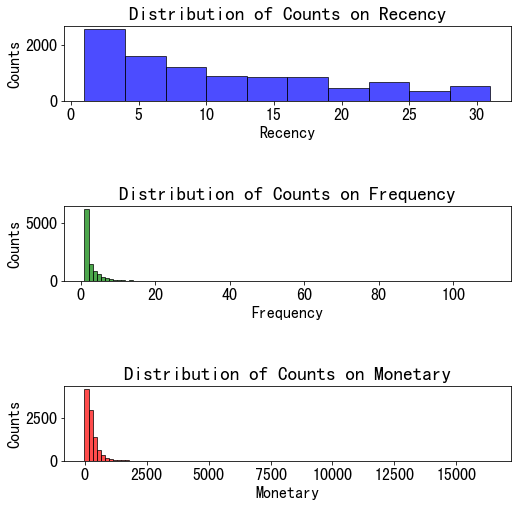

In [18]:
plt.figure(figsize=(8,8))

plt.subplot(511)
plt.hist(raw_data['elapsed_days'], bins=10, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel('Recency')
plt.ylabel('Counts')
plt.title('Distribution of Counts on Recency',fontweight ="bold")

plt.subplot(513)
plt.hist(raw_data['transaction_count'], bins=100, facecolor="green", edgecolor="black", alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Counts')
plt.title('Distribution of Counts on Frequency',fontweight ="bold")

plt.subplot(515)
plt.hist(raw_data['amount_total'], bins=100, facecolor="red", edgecolor="black", alpha=0.7)
plt.xlabel('Monetary')
plt.ylabel('Counts')
plt.title('Distribution of Counts on Monetary',fontweight ="bold")
plt.show()

In [19]:
# 0 : Recency : 10
# 1 : Frequency : 5
# 2 : Monetary : 200
matrixRFM = [10,5,200]

# ------------------R---F---M----
# 7 : 重要价值客户----1---1---1----
# 6 : 一般价值客户----1---1---0----
# 5 : 重要发展客户----1---0---1----
# 4 : 一般发展客户----1---0---0----
# 3 : 重要保持客户----0---1---1----
# 2 : 一般保持客户----0---1---0----
# 1 : 重要挽留客户----0---0---1----
# 0 : 一般挽留客户----0---0---0----
def encodingRFM(r,f,m):
    i1 = 1 if r < matrixRFM[0] else 0
    i2 = 1 if f > matrixRFM[1] else 0
    i3 = 1 if m > matrixRFM[2] else 0
    re = 4*i1 + 2*i2 + i3
    return re

# unit test for encoding RFM
# print(encodingRFM(2,0))
# print(encodingRFM(1000,2))

# taggerize customers based on RFM thresholds
raw_data['RFM'] = raw_data.apply(lambda row:encodingRFM(row['elapsed_days'],
                                                       row['transaction_count'],
                                                       row['amount_total']), axis = 1 )

raw_data.head(5)

,member_id,transaction_count,interval_avg,elapsed_days,amount_total,amount_transaction_avg,class_total,week_count,weekMorning_count,weekEvening_count,weekNorm_count,weekend_count,weekMorning_amount,weekEvening_amount,weekNorm_amount,weekend_amunt,attrition,RFM
0,1449.0,3.0,5.666667,1.0,385.51,128.503333,20.0,3.0,0.0,1.0,0.0,2.0,0.0,100.61,0.00,284.90,0.0,5
1,6183.0,2.0,0.500000,1.0,243.80,121.900000,7.0,1.0,0.0,0.0,0.0,2.0,0.0,0.00,0.00,243.80,1.0,5
2,6780.0,5.0,4.000000,1.0,400.74,80.148000,22.0,3.0,0.0,1.0,0.0,4.0,0.0,95.99,0.00,304.75,0.0,5
3,112.0,4.0,4.500000,1.0,270.53,67.632500,12.0,3.0,0.0,1.0,1.0,2.0,0.0,45.03,164.26,61.24,0.0,5
4,5058.0,3.0,0.333333,1.0,405.20,135.066667,5.0,1.0,0.0,0.0,0.0,3.0,0.0,0.00,0.00,405.20,0.0,5


In [20]:
df_rfm = raw_data.groupby('RFM').agg({'weekMorning_count' : np.sum,
                             'weekEvening_count':np.sum,
                             'weekNorm_count':np.sum,
                             'weekend_count':np.sum})
for i in df_rfm.index:
    df_rfm.loc[i,'count'] = raw_data[raw_data['RFM'] == i].shape[0]
    df_rfm.loc[i,'weekM_'] = df_rfm.loc[i,'weekMorning_count']/df_rfm.loc[i,'count']
    df_rfm.loc[i,'weekE_'] = df_rfm.loc[i,'weekEvening_count']/df_rfm.loc[i,'count']
    df_rfm.loc[i,'weekN_'] = df_rfm.loc[i,'weekNorm_count']/df_rfm.loc[i,'count']
    df_rfm.loc[i,'weekend_'] = df_rfm.loc[i,'weekend_count']/df_rfm.loc[i,'count']
df_rfm

,weekMorning_count,weekEvening_count,weekNorm_count,weekend_count,count,weekM_,weekE_,weekN_,weekend_
RFM,,,,,,,,,
0,281.0,459.0,2028.0,1307.0,2973.0,0.094517,0.154390,0.682139,0.439623
1,110.0,534.0,1684.0,1273.0,1562.0,0.070423,0.341869,1.078105,0.814981
2,8.0,10.0,15.0,17.0,8.0,1.000000,1.250000,1.875000,2.125000
3,38.0,99.0,293.0,154.0,77.0,0.493506,1.285714,3.805195,2.000000
4,346.0,393.0,1838.0,1722.0,2197.0,0.157487,0.178880,0.836595,0.783796
5,223.0,918.0,2724.0,3098.0,2258.0,0.098760,0.406554,1.206377,1.372011
6,107.0,58.0,202.0,160.0,72.0,1.486111,0.805556,2.805556,2.222222
7,700.0,1153.0,3328.0,2762.0,853.0,0.820633,1.351700,3.901524,3.237984


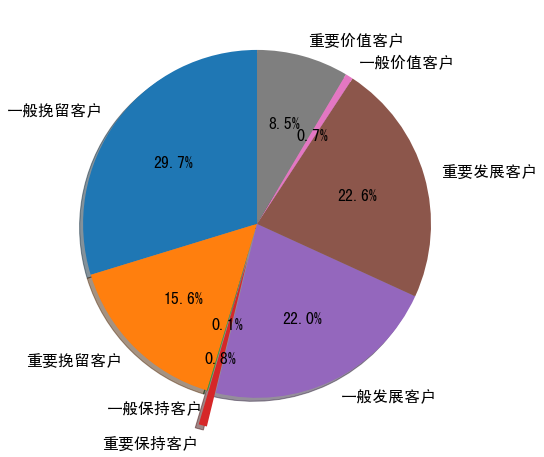

In [21]:
plt.figure(figsize=(8,8))
labels = '一般挽留客户','重要挽留客户', '一般保持客户','重要保持客户','一般发展客户','重要发展客户','一般价值客户','重要价值客户'
count = df_rfm['count']
explode = (0, 0, 0, 0.2, 0, 0, 0, 0) 
plt.pie(count, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

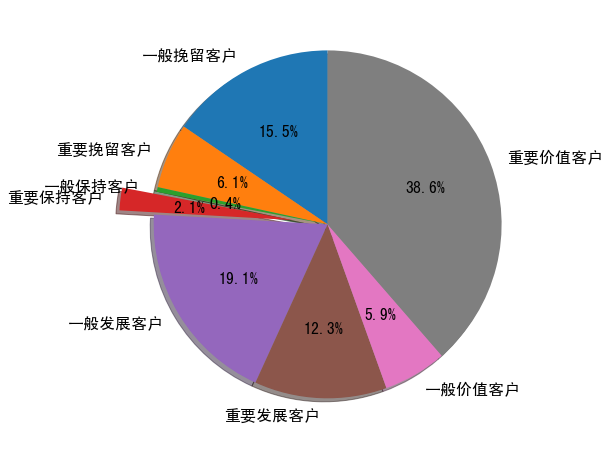

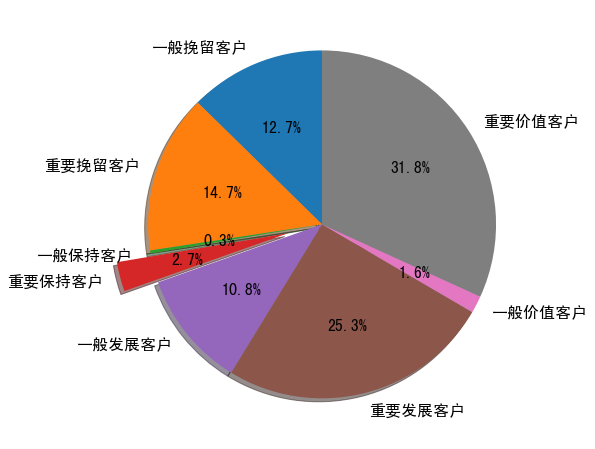

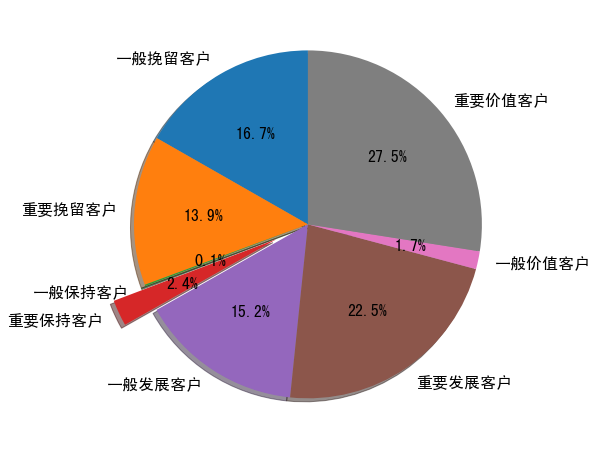

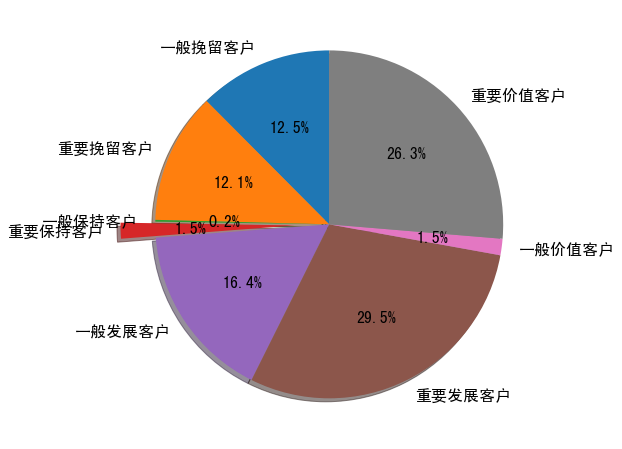

In [22]:
plt.figure(figsize=(8,8))
labels = '一般挽留客户','重要挽留客户', '一般保持客户','重要保持客户','一般发展客户','重要发展客户','一般价值客户','重要价值客户'
count = df_rfm['weekMorning_count']
#print(count)
explode = (0, 0, 0, 0.2, 0, 0, 0, 0) 
plt.pie(count, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

plt.figure(figsize=(8,8))
labels = '一般挽留客户','重要挽留客户', '一般保持客户','重要保持客户','一般发展客户','重要发展客户','一般价值客户','重要价值客户'
count = df_rfm['weekEvening_count']
#print(count)
explode = (0, 0, 0, 0.2, 0, 0, 0, 0) 
plt.pie(count, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

plt.figure(figsize=(8,8))
labels = '一般挽留客户','重要挽留客户', '一般保持客户','重要保持客户','一般发展客户','重要发展客户','一般价值客户','重要价值客户'
count = df_rfm['weekNorm_count']
#print(count)
explode = (0, 0, 0, 0.2, 0, 0, 0, 0) 
plt.pie(count, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

plt.figure(figsize=(8,8))
labels = '一般挽留客户','重要挽留客户', '一般保持客户','重要保持客户','一般发展客户','重要发展客户','一般价值客户','重要价值客户'
count = df_rfm['weekend_count']
#print(count)
explode = (0, 0, 0, 0.2, 0, 0, 0, 0) 
plt.pie(count, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

In [23]:
result = pd.merge(df_goods,df_categrozied.loc[:,['class_full','parent_class']],how='left',on = 'class_full')

# Some advanced learning of churn analysis through mechanidse categorization
df_transactions = result.pivot_table(columns = "parent_class",
                                     index="member_id",values="quantity",aggfunc=np.sum).fillna(0)



df_transactions.head(5)

parent_class,00_蔬菜水果,01_鸡鸭鱼肉,02_散装食品,03_蛋奶制品,04_烹饪辅料,05_主食,06_母婴用品,07_宠物用品,08_保健品,09_酒类,10_饮料综合,11_服饰鞋类箱包,12_个人护理,13_家用综合,14_清洁用品,15_办公文具,16_家居用品,17_玩具,18_汽车用品,19_数码产品
member_id,,,,,,,,,,,,,,,,,,,,
1,4.71,0.00,13.10,2.0,7.0,26.0,1.0,0.0,0.0,0.0,4.0,1.0,6.0,2.0,5.0,0.0,5.0,0.0,0.0,0.0
2,0.96,1.64,0.00,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.16,3.26,8.32,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0
4,14.41,0.00,10.21,2.0,4.0,11.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.00,0.00,0.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#join to expand the original raw data to have include more behavioral information

new_raw = raw_data.set_index('member_id').join(df_transactions)
new_raw.reset_index(inplace=True)
new_raw.head(5)

,member_id,transaction_count,interval_avg,elapsed_days,amount_total,amount_transaction_avg,class_total,week_count,weekMorning_count,weekEvening_count,...,10_饮料综合,11_服饰鞋类箱包,12_个人护理,13_家用综合,14_清洁用品,15_办公文具,16_家居用品,17_玩具,18_汽车用品,19_数码产品
0,1449.0,3.0,5.666667,1.0,385.51,128.503333,20.0,3.0,0.0,1.0,...,8.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,6183.0,2.0,0.500000,1.0,243.80,121.900000,7.0,1.0,0.0,0.0,...,0.0,0.0,2.0,2.0,0.0,3.0,8.0,0.0,0.0,0.0
2,6780.0,5.0,4.000000,1.0,400.74,80.148000,22.0,3.0,0.0,1.0,...,0.0,2.0,1.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0
3,112.0,4.0,4.500000,1.0,270.53,67.632500,12.0,3.0,0.0,1.0,...,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5058.0,3.0,0.333333,1.0,405.20,135.066667,5.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [25]:
x_data = new_raw.drop(['member_id','attrition'],axis=1) 
y_data = new_raw['attrition']

x_data.columns

Index(['transaction_count', 'interval_avg', 'elapsed_days', 'amount_total',
       'amount_transaction_avg', 'class_total', 'week_count',
       'weekMorning_count', 'weekEvening_count', 'weekNorm_count',
       'weekend_count', 'weekMorning_amount', 'weekEvening_amount',
       'weekNorm_amount', 'weekend_amunt', 'RFM', '00_蔬菜水果', '01_鸡鸭鱼肉',
       '02_散装食品', '03_蛋奶制品', '04_烹饪辅料', '05_主食', '06_母婴用品', '07_宠物用品',
       '08_保健品', '09_酒类', '10_饮料综合', '11_服饰鞋类箱包', '12_个人护理', '13_家用综合',
       '14_清洁用品', '15_办公文具', '16_家居用品', '17_玩具', '18_汽车用品', '19_数码产品'],
      dtype='object')

In [26]:
df_basket_raw.head(10)

class_full,001_绿叶蔬菜,002_根茎蔬菜,003_水果蔬菜,004_包装蔬菜,005_菇类蔬菜,006_无毒蔬菜,007_新鲜水果,008_豆制品,009_花卉园艺,010_茶叶,...,190_电脑及配件,191_学习机/电子词典,192_寄售vcd,193_男鞋,194_女鞋,195_童鞋,196_运动帆布鞋,197_电视,198_餐具,200_家用一次性用品
basket_no,,,,,,,,,,,,,,,,,,,,,
10000_0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1000_3,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001_1,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002_4,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003_2,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.45,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004_0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004_1,0.0,0.00,0.00,0.0,1.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005_3,0.0,0.85,1.03,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1006_1,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
def isChurn(basket_no):
    return np.min(df_goods[df_goods['member_id'] == int(basket_no[:-2])]['Attrition (Y)'])

def raw_to_word(df):
    return 0

df_retain = pd.DataFrame(columns=df_basket_raw.columns)
df_attrition = pd.DataFrame(columns=df_basket_raw.columns)

total = df_basket_raw.shape[0]
count = 0

attrition_list = df_goods[df_goods['Attrition (Y)'] == 1]['member_id'].unique()

for index,row in df_basket_raw.iterrows():
    if isChurn(index) == 1:
        df_attrition = df_attrition.append(row)
    else:
        df_retain = df_retain.append(row)
    count += 1
    if count%500 == 0 or count == total:
        print(str(datetime.now()) + ' : ' + str(count) + ' of ' + str(total) + ' completed')
        
df_attrition.head(10)

2021-04-19 23:24:39.134094 : 500 of 19236 completed
2021-04-19 23:24:40.504900 : 1000 of 19236 completed
2021-04-19 23:24:42.097630 : 1500 of 19236 completed
2021-04-19 23:24:43.876441 : 2000 of 19236 completed
2021-04-19 23:24:45.813812 : 2500 of 19236 completed
2021-04-19 23:24:47.907234 : 3000 of 19236 completed
2021-04-19 23:24:49.904804 : 3500 of 19236 completed
2021-04-19 23:24:52.087634 : 4000 of 19236 completed
2021-04-19 23:24:54.325627 : 4500 of 19236 completed
2021-04-19 23:24:56.785758 : 5000 of 19236 completed
2021-04-19 23:24:59.397224 : 5500 of 19236 completed
2021-04-19 23:25:02.272725 : 6000 of 19236 completed
2021-04-19 23:25:05.188583 : 6500 of 19236 completed
2021-04-19 23:25:08.344716 : 7000 of 19236 completed
2021-04-19 23:25:11.877257 : 7500 of 19236 completed
2021-04-19 23:25:15.739525 : 8000 of 19236 completed
2021-04-19 23:25:19.450446 : 8500 of 19236 completed
2021-04-19 23:25:23.643151 : 9000 of 19236 completed
2021-04-19 23:25:27.961037 : 9500 of 19236 comp

class_full,001_绿叶蔬菜,002_根茎蔬菜,003_水果蔬菜,004_包装蔬菜,005_菇类蔬菜,006_无毒蔬菜,007_新鲜水果,008_豆制品,009_花卉园艺,010_茶叶,...,190_电脑及配件,191_学习机/电子词典,192_寄售vcd,193_男鞋,194_女鞋,195_童鞋,196_运动帆布鞋,197_电视,198_餐具,200_家用一次性用品
10000_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1000_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.45,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004_1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1013_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1016_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1017_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
def df_to_word(df,file):
    # start from empty string
    data = [] 
    # count & total
    count = 0
    total = df.shape[0]
    for index,row in df.iterrows():
        for col in df.columns:
            if row[col] > 0:
                data.append(col[4:]+' ')
        count += 1
        if count%500 == 0 or count == total:
            print(str(datetime.now()) + ' : ' 
                  + str(count) + ' of ' 
                  + str(total) + ' completed')
    with open(file,"w") as f:
        f.writelines(data)
    f.close()

df_to_word(df_attrition,'attrition.txt')
df_to_word(df_retain,'retain.txt')

2021-04-19 23:27:17.141112 : 500 of 3674 completed
2021-04-19 23:27:17.439374 : 1000 of 3674 completed
2021-04-19 23:27:17.771722 : 1500 of 3674 completed
2021-04-19 23:27:18.058369 : 2000 of 3674 completed
2021-04-19 23:27:18.353541 : 2500 of 3674 completed
2021-04-19 23:27:18.639001 : 3000 of 3674 completed
2021-04-19 23:27:18.928440 : 3500 of 3674 completed
2021-04-19 23:27:19.028951 : 3674 of 3674 completed
2021-04-19 23:27:19.323082 : 500 of 15562 completed
2021-04-19 23:27:19.608024 : 1000 of 15562 completed
2021-04-19 23:27:19.913708 : 1500 of 15562 completed
2021-04-19 23:27:20.210662 : 2000 of 15562 completed
2021-04-19 23:27:20.499344 : 2500 of 15562 completed
2021-04-19 23:27:20.789133 : 3000 of 15562 completed
2021-04-19 23:27:21.077578 : 3500 of 15562 completed
2021-04-19 23:27:21.365794 : 4000 of 15562 completed
2021-04-19 23:27:21.654635 : 4500 of 15562 completed
2021-04-19 23:27:21.951965 : 5000 of 15562 completed
2021-04-19 23:27:22.242840 : 5500 of 15562 completed
202

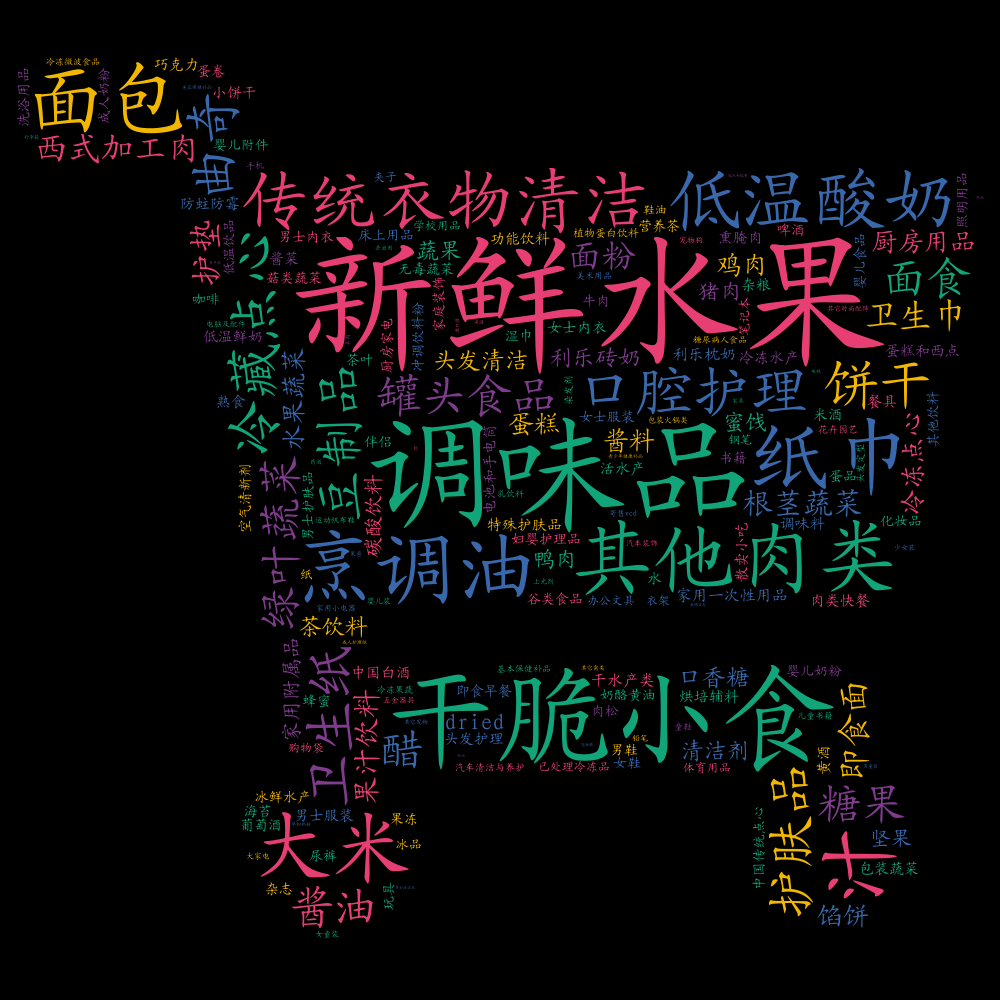

In [48]:
import stylecloud
from IPython.display import Image

stylecloud.gen_stylecloud(file_path='attrition.txt',
                          collocations=False,
                          background_color="black",
                          font_path=r'simkai.ttf',
                          max_font_size=150,
                          size=1000,
                          icon_name='fas fa-shopping-cart',
                          output_name='attrition.png')
Image(filename='attrition.png')

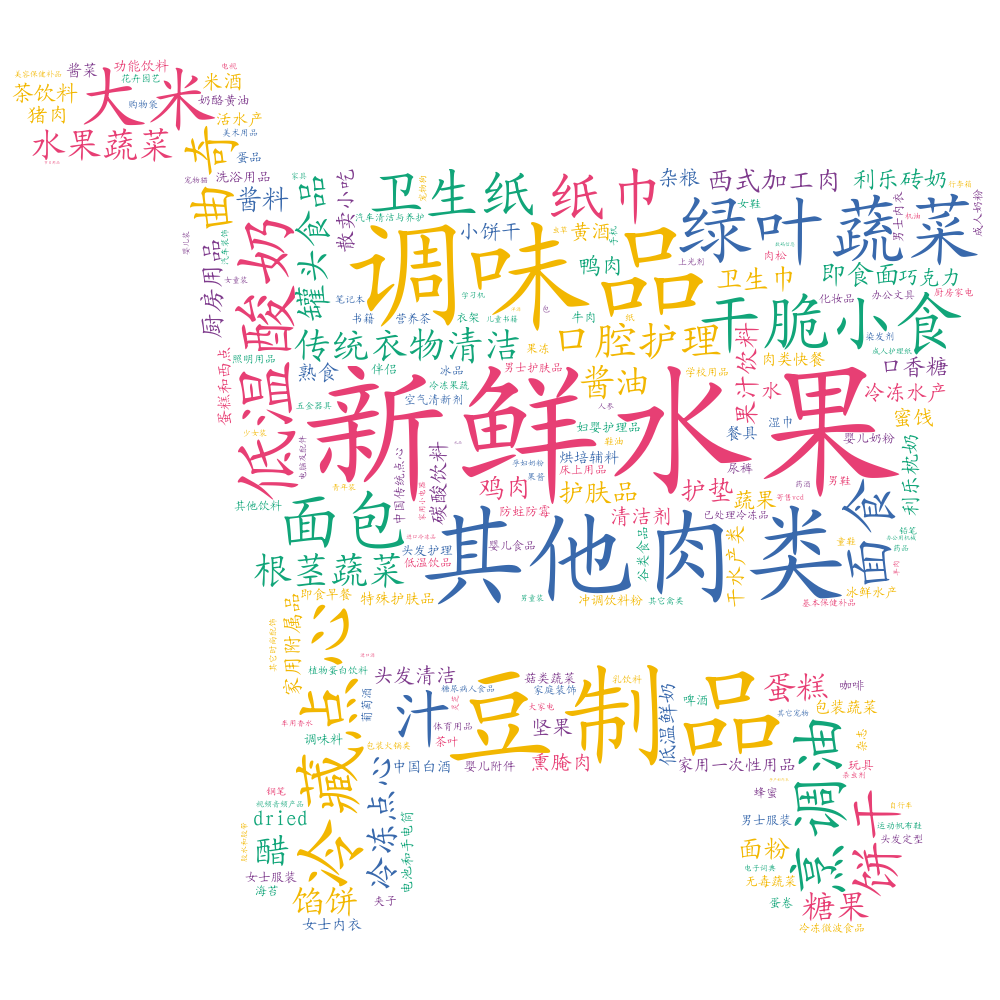

In [47]:
stylecloud.gen_stylecloud(file_path='retain.txt',
                          collocations=False,
                          background_color="white",
                          font_path=r'simkai.ttf',
                          max_font_size=150,
                          size=1000,
                          icon_name='fas fa-shopping-cart',
                          output_name='retain.png')
Image(filename='retain.png')